# Quantum Kernel Estimator Challenge

For the first leg of the QML challenge, you implemented a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Now, you will build on that experience, and explore Havlicek et al.'s second proposed method of applying quantum-enhanced feature spaces to machine learning: the *quantum kernel estimator*. In this challenge continuation, you will construct a QML model that estimates a kernel function using a quantum computer and optimize a classical support vector machine (SVM). For this classification protocol, we will continue to restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$.

Compared to the VQC challenge, we are providing very little template code for this kernel estimator challenge. This is by design to enable teams to further differentiate their model, especially in the training phase. The [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf) paper is your best resource, and the [Kernel-based training Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html) may also be helpful. You are free to import and use any additional packages that you wish.

In [1]:
!qbraid jobs enable haqs  # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [2]:
TEAM_NAME = "Reverse chandelier"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from scipy.optimize import minimize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1, −1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

In [4]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [5]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)

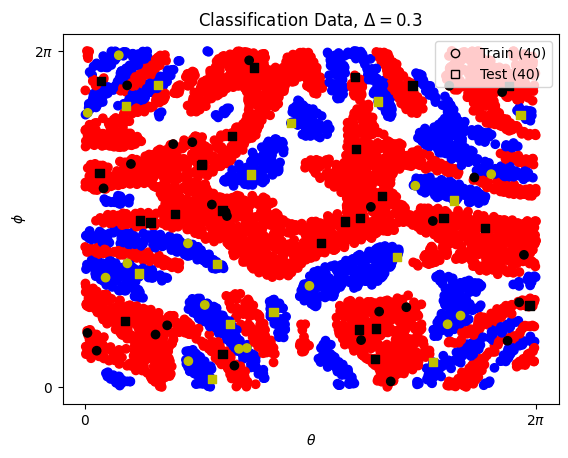

In [6]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

In [7]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [8]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

In [9]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [10]:
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    # TODO
    # for i in range(n_wires):
    #     qml.Hadamard(wires=i)

    for i in range(n_wires):
        qml.RZ(2*x[i], wires=i)

    for s in pset:
        qml.CNOT(wires=s)
        qml.RZ(2*x[2], wires=s[1])
        qml.CNOT(wires=s)
        
    #second set
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    for i in range(n_wires):
        qml.RZ(2*x[i], wires=i)

    for s in pset:
        qml.CNOT(wires=s)
        qml.RZ(2*x[2], wires=s[1])
        qml.CNOT(wires=s)

## Quantum kernel (ideal)

In [11]:
dev_kernel = qml.device("default.qubit", wires=n_wires)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1


@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)

    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [12]:
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

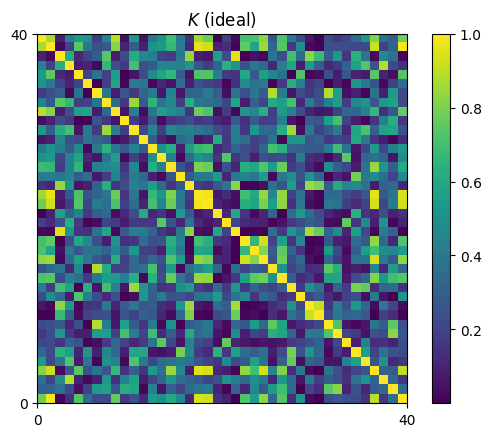

In [13]:
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)

k_ideal = kernel_ideal(X_train, X_train)

im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")
plt.show()

## Quantum kernel estimator

Here it will be convenient to write $T = \left\{\textbf{x}_1,...,\textbf{x}_t\right\}$ with $t = \left|T\right|$; also let $y_i = m(\textbf{x}_i)$ be the corresponding label. In this protocol you will use a quantum computer to estimate the $t \times t$ kernel matrix $K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$. For all pairs of points $\textbf{x}_i, \textbf{x}_j \in T$ in the the training data, you will sample the overlap between feature states to obtain the matrix entry in the kernel. This fidelity can be estimated from the output probability of the circuit by sampling the output distribution with $R$ shots and only taking the $0^n$ count. The frequency of the $0^n$ count is an estimator of the Kernel entry up to an error $\epsilon = O(R^{−1/2})$. After the kernel matrix for the full training data has been constructed we use the conventional (classical) support vector machine classifier. The optimal hyperplane can be found by solving the dual quadratic program $L_D$ for the variables $\alpha = \left\{\alpha_i\right\}_{i=1...t}$. Hence, to train, we maximize

\begin{equation}
L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j),
\label{eq:Ld} \tag{1}
\end{equation}

subject to $\sum_{i=1}^t \alpha_i y_i = 0$ and $\alpha_i \geq 0$. This problem is concave, and therefore efficiently solvable, whenever $K(\textbf{x}_i, \textbf{x}_j)$ is a positive definite matrix. Standard quadratic programming solvers can be used. The solution to this problem will be given by a nonnegative vector $\alpha^* = (\alpha_1^*,...,\alpha_t^*)$. Due to complementary slackness, we expect that many of the $\alpha_i^*$ will be zero. Hence, there will only be subset of training samples that are needed to construct the optimal hyperplane. These samples are referred to as the support vectors.

The training phase consists of the following steps:

---
### Algorithm 1: training
1. **Input** Labeled training samples $T = \left\{ \textbf{x} \in \Omega \in {\rm I\!R}^n \right\} \times \left\{ y \in C \right\}$, quadratic program solver.
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ **do**
5. $\hspace{5mm}$ **for** $\textit{j} = 1$ to $\textit{t}$ **do**
6. $\hspace{10mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{10mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{15mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{x}_j$.
9. $\hspace{15mm}$ Measure outcome in $Z$-basis.
10. $\hspace{15mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{20mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{15mm}$ **end if**
13. $\hspace{10mm}$ **end for**
14. $\hspace{10mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{x}_j) = r_{0^n}R^{-1}$.
15. $\hspace{5mm}$ **end for**
16. **end for**
17. Use quadratic program solver to optimize $\alpha$ in $L_D$ in eqn. (1) with kernel $K = \hat{K}$ and set $T$.
18. **return** the final parameters $\alpha^*$ and value of the cost function $L_D$ and kernel estimator $\hat{K}$.
---

In [14]:
shots = 1000

dev_est = qml.device("default.qubit", wires=n_wires, shots=shots)


@qml.qnode(dev_est)
def fidelity_estimate(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector
        
    Returns:
        shape (2, `R`) tensor containing `R` Z-basis measurement samples on each qubit, where `R` 
        is the number of shots determined from the dev.shots attribute of the corresponding device.

    """
    x_enc = encode_data(x)
    z_enc = encode_data(z)
    results = []
    
    #for num_shots in range(shots):
    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)

    #qml.expval(qml.PauliZ(i_wire)) for i_wire in range(n_wires)
    
        
    return qml.probs(wires=[0, 1])

    # TODO (hint: Havlicek Fig. 2.c.)

In [15]:
fidelity_estimate(X_train[0],X_train[1])

tensor([0.869, 0.053, 0.077, 0.001], requires_grad=True)

In [16]:
def kernel_experimental(A, B):
    """Experimentally estimated kernel matrix for sets A and B."""

    # TODO
    return np.array([[fidelity_estimate(a, b)[0] for b in B] for a in A])

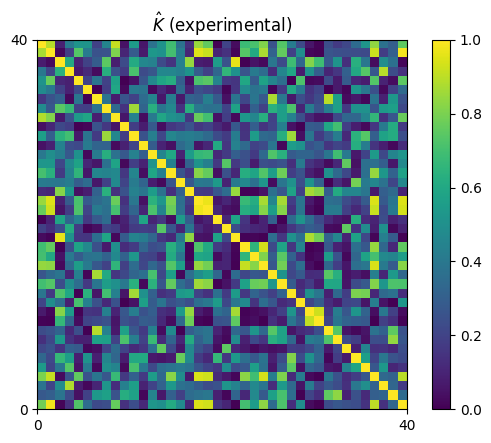

In [17]:
# Visualize experimental kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (left)

k_experimental = kernel_experimental(X_train, X_train)

im = plt.imshow(k_experimental, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (experimental)")
plt.show()

In [18]:
# cost_values = []

In [19]:
# TODO: Implement training algorithm
ZERO = 1e-7

def Lagrange_dual(alpha,Y,K):
    result = 0
    indexes = np.where(alpha > ZERO)[0]
    for i in indexes:
        for j in indexes:
            result = result + (alpha[i]*alpha[j]*Y[i]*Y[j]*K[i][j])
    result = 0.5*result - sum(alpha)
    # cost_values.append(result)
    return result

In [20]:
#Optimization
import scipy
from scipy.optimize import Bounds,BFGS
from scipy.optimize import LinearConstraint,minimize
def optimize_alpha(K,Y,C):
    m,n = K.shape
    np.random.seed(1)
    alpha_0 = np.random.rand(m)*C
    linear_constraint = LinearConstraint(Y,[0],[0])
    bounds_alpha = Bounds(np.zeros(m),np.full(m,C))
    result = minimize(Lagrange_dual,alpha_0,args=(Y,K),method='trust-constr',hess=BFGS(),constraints=[linear_constraint],bounds=bounds_alpha)
    alpha = result.x
    return alpha

In [21]:
alpha_list = optimize_alpha(k_experimental,Y_train,10)

In [22]:
print(alpha_list)

[7.73671330e-01 2.26924820e-07 9.63620087e+00 9.99999993e+00
 9.99999977e+00 1.43333550e-07 8.48114595e+00 9.99999996e+00
 7.10925910e-08 3.92087295e+00 9.99999643e+00 6.86390443e+00
 3.30644354e+00 3.78288527e+00 7.29920513e+00 7.45935445e-08
 9.99999975e+00 1.37339451e-07 5.26806046e+00 1.31542202e-07
 9.99999992e+00 9.99999953e+00 9.99999977e+00 9.99999994e+00
 9.99999996e+00 9.99999994e+00 5.78382948e+00 4.90438248e-10
 4.74383036e+00 9.99999995e+00 5.79301984e+00 9.99999994e+00
 9.99999991e+00 7.15756877e-08 5.26861988e-08 1.51131099e-07
 9.99999996e+00 1.03929079e-07 7.13319119e+00 1.25119244e-07]


In the classification phase, we want to assign a label to a new datum $s \in S$ of the test set. For this, the inner products $K(\textbf{x}_i, \textbf{s})$ between all support vectors $\textbf{x}_j \in T$ with $\alpha_i^* > 0$ and the new datum s have to be estimated on the quantum computer, c.f. Havlicek Fig. S5.b. The new label $\tilde{m}(\textbf{s})$ for the datum is assigned according to Havlicek eqn. (14). Since all support vectors are known from the training phase and we have obtained access to the kernel $K(\textbf{x}_i,\textbf{s})$ from the quantum hardware, the label can be directly computed according to


\begin{equation}
\tilde{m}(\textbf{s}) = \text{sign} \bigg(\sum_{i=1}^t y_i \alpha_i^* K(\textbf{x}_i, \textbf{s}) + b \bigg).
\label{eq:ms} \tag{2}
\end{equation}

Note that the bias $b$ in $\tilde{m}(\textbf{s})$ can be calculated from the weights $\alpha_i^*$ by choosing any $i$ with $\alpha_i^* > 0$ and solving $\sum_j y_j \alpha_j^* K(\textbf{x}_j, \textbf{x}_i) + b = y_i$ for $b$.

---
### Algorithm 2: classification
1. **Input** An unlabeled sample from the test set $\textbf{s} \in S$, optimal SVM parameters $\alpha, b$ and training data set $T$. 
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ with $\alpha_i^* > 0$ **do**
5. $\hspace{5mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{5mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{10mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{s}$.
9. $\hspace{10mm}$ Measure outcome in $Z$-basis.
10. $\hspace{10mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{15mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{10mm}$ **end if**
13. $\hspace{5mm}$ **end for**
14. $\hspace{5mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{s}) = r_{0^n}R^{-1}$.
15. **end for**
16. **return** $\text{sign}\big(\sum_{i=1}^t y_i \alpha_i^* \hat{K}(\textbf{x}_i, \textbf{s}) + b \big)$.
---

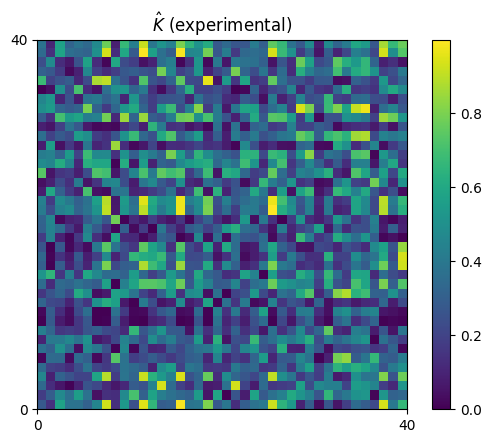

In [23]:
k_experimental_test = kernel_experimental(X_train, X_test)

im = plt.imshow(k_experimental_test, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (experimental)")
plt.show()

In [24]:
# TODO: Implement classification algorithm
def get_w(alpha,Y,K):
    m = len(K)
    w = np.zeros(K.shape[1])
    for i in range(m):
        w = w + alpha[i]*Y[i]*K[i,:]
    return w

In [25]:
# def get_bias(alpha,Y,K,C):
#     C_numeric = C - ZERO
#     indexes = np.where((alpha > ZERO)&(alpha <C_numeric))[0]
#     w0 = 0.0
#     i = indexes[0]
#     for j in indexes:
#         w0 = w0 + (Y[j]*alpha[j]*K[j][i])
#     bias = Y[i] - w0
#     bias = bias / len(indexes)
#     return bias

In [26]:
def get_w0(alpha,Y,w,K,C):
    C_numeric = C - ZERO
    indexes = np.where((alpha > ZERO)&(alpha <C_numeric))[0]
    w0 = 0.0
    for s in indexes:
        w0 = w0 + Y[s] - np.dot(K[s,:],w)
    w0 = w0 /len(indexes)
    return w0

In [27]:
def classification(K,w,w0):
    pred = w + w0
    pred = np.sign(pred)
    pred[pred==0] = 1
    return pred

In [28]:
# TODO: Test accuracy
def accuracy(labels,pred):
    total = len(labels)
    errors = sum(labels != pred)
    return errors/total*100

In [29]:
w = get_w(alpha_list,Y_train,k_experimental_test)
print(w)

[-1.54070227  0.69149195  3.04795419  1.66918796 -0.58400316  1.32885634
 -0.20981565  0.75848102  1.85422561  3.10198319  1.62297617  0.43449785
 -0.51845286 -3.14055342  0.14423256  1.05969314  1.68820076  1.85037567
  0.83477525  2.80229524  0.06652087 -3.34855764  0.25530972  1.70134701
  2.90121121 -0.23954093  3.43062896  0.39385808 -0.30533515  0.43295853
 -3.46463742 -0.56395782  1.65412836  3.8441573  -0.92900395  0.57385015
  0.23580469  0.38731162  2.0760615  -0.49262443]


In [30]:
w0  = get_w0(alpha_list,Y_train,w,k_experimental_test,10)
#w0  = get_bias(alpha_list,Y_train,k_experimental,10)
print(w0)

-7.9287995626327215


In [31]:
pred = classification(k_experimental_test,w,w0)
print(accuracy(Y_test,pred))

65.0


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm = SVC(kernel=kernel_experimental).fit(X_train,Y_train)
predictions = svm.predict(X_test)
accuracy_score(predictions,Y_test)

0.7